In [603]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import plotly.express as px # interactive plots

# Display all columns
pd.set_option('display.max_columns', None)

We will use this file to clean the csv file we created via web scraping. Below is a list of changes:
- make everything lowercase
- get rid of empty values
- split experience into two columns, one for lower-case, one for upper-case
- try to standardize job roles (i.e. 'data scientist = data scientist 1') ? 
- likewise standardize skills list

In [604]:
# Load the data
# Define file path
DATA_PATH = "../data/raw/DataScience_jobs.csv"

try:
    df = pd.read_csv(DATA_PATH, index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: File not found.")

# Preview
df.head()


Data loaded successfully.


,roles,companies,locations,experience,skills
0,Data Scientist,Ltimindtree,"Hybrid - Hyderabad, Chennai, Bengaluru",8-13 Yrs,"Data Science, Gen ai, Python, Data, Science, G..."
1,Urgent Hiring For FullStack-Data Scientist-Imm...,Genpact,"Hybrid - Gurugram, Bengaluru",7-12 Yrs,"Natural Language Processing, Machine Learning ..."
2,Sr. Data Scientist,NaN,NaN,NaN,NaN
3,Artificial Intelligence Developer,NaN,NaN,NaN,NaN
4,Data Science Manager,NaN,NaN,NaN,NaN


In [605]:
print(f"Columns: {df.columns.tolist()}")
print(f"Shape: {df.shape}")


Columns: ['roles', 'companies', 'locations', 'experience', 'skills']
Shape: (1009, 5)


In [606]:
# get rid of rows with missing values
df.isna().sum()
df = df.dropna()


In [607]:
df.isna().sum()

roles         0
companies     0
locations     0
experience    0
skills        0
dtype: int64

In [608]:
# See how many rows are left
df.shape

(981, 5)

In [609]:
# let's lower case all strings in all columns
df = df.apply(lambda x: x.astype(str).str.lower())
df.head()

,roles,companies,locations,experience,skills
0,data scientist,ltimindtree,"hybrid - hyderabad, chennai, bengaluru",8-13 yrs,"data science, gen ai, python, data, science, g..."
1,urgent hiring for fullstack-data scientist-imm...,genpact,"hybrid - gurugram, bengaluru",7-12 yrs,"natural language processing, machine learning ..."
7,data scientist,wipro,bengaluru,2-7 yrs,"time series analysis, python, machine learning..."
8,rbl bank | hiring for data scientist - airoli,rbl finserve,mumbai (all areas),4-8 yrs,"data science, python, insights, machine learni..."
9,data scientist,o9 solutions,bengaluru,2-4 yrs,"supply chain, coding, project management, busi..."


In [610]:
# check for any duplicates
# get a series of booleans (T if a duplicate, F if unique)
df.duplicated(subset=["roles","companies","locations","experience","skills"])
total_duplicates = df.duplicated(subset=["roles","companies","locations","experience","skills"]).sum()
print(f"{total_duplicates} duplicates")

df.drop_duplicates(keep="first",inplace=True)
df.shape

23 duplicates


(958, 5)

In [611]:
# some entries have multiple locations and/or skills
# so we will split these long strings into a list
df.locations = [location.split(",") for location in df.locations]
df.skills = [skill.split(",") for skill in df.skills]

In [612]:
# let's check what the df looks like now
df.locations.tolist()[0:4]

[['hybrid - hyderabad', ' chennai', ' bengaluru'],
 ['hybrid - gurugram', ' bengaluru'],
 ['bengaluru'],
 ['mumbai (all areas)']]

In [613]:
# remove white spaces
df['locations'] = df['locations'].apply(lambda locs: [loc.strip() for loc in locs])
print(df['locations'].tolist()[0:4])

df['skills'] = df['skills'].apply(lambda x: [skills.strip() for skills in x])
print(df['skills'].tolist()[0:2])

[['hybrid - hyderabad', 'chennai', 'bengaluru'], ['hybrid - gurugram', 'bengaluru'], ['bengaluru'], ['mumbai (all areas)']]
[['data science', 'gen ai', 'python', 'data', 'science', 'gen', 'artificial intelligence'], ['natural language processing', 'machine learning algorithms', 'object oriented programming', 'large language models', 'python', 'oops programming', 'ml algorithms', 'deep learning']]


In [614]:
# let's standardize the experience
# get rid of ' yrs'

df['experience'].tolist()[0:20]

['8-13 yrs',
 '7-12 yrs',
 '2-7 yrs',
 '4-8 yrs',
 '2-4 yrs',
 '3-7 yrs',
 '2-6 yrs',
 '3-6 yrs',
 '3-8 yrs',
 '2-7 yrs',
 '2-5 yrs',
 '3-6 yrs',
 '3-6 yrs',
 '3-8 yrs',
 '0-3 yrs',
 '3-6 yrs',
 '4-9 yrs',
 '5-10 yrs',
 '3-8 yrs',
 '3-7 yrs']

In [615]:
# remove ' yrs'
df['experience'] = df['experience'].apply(lambda x: x.replace(" yrs",""))
# change experience to a list with [int, int]
# remove '-'
df['experience'] = df['experience'].apply(lambda x: x.split("-"))
df['experience'] = df['experience'].apply(lambda x: [int(num) for num in x])
df['experience']


0       [8, 13]
1       [7, 12]
7        [2, 7]
8        [4, 8]
9        [2, 4]
         ...   
1004     [2, 3]
1005     [3, 7]
1006    [4, 10]
1007     [2, 3]
1008     [4, 8]
Name: experience, Length: 958, dtype: object

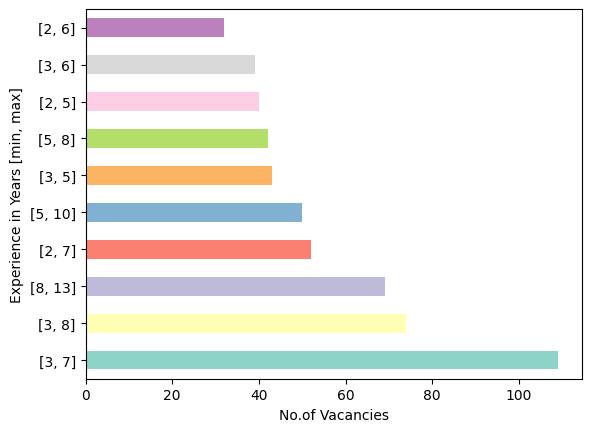

In [616]:
# link of differnt collor pallets: https://matplotlib.org/stable/users/explain/colors/colormaps.html
colors = plt.cm.Set3.colors[:15]  # You can try 'Accent', 'tab10', or 'Dark2' for variety.

# make a bar plot showing desired experience
exp_count = df['experience'].value_counts()[:10]
exp_count.plot.barh(color=colors)
plt.xlabel("No.of Vacancies")
plt.ylabel("Experience in Years [min, max]")
plt.show()

In [617]:
# create a new feature that holds only minimum/maximum desired experience

# let's find cases where the experience column doesn't hold a list of 2 ints
filtered_df = df[df['experience'].apply(lambda x: len(x) != 2)]
filtered_df.shape
filtered_df

,roles,companies,locations,experience,skills
310,data analyst / data scientist / data engineer ...,rudder analytics,[remote],[0],"[data analytics, business intelligence, data e..."


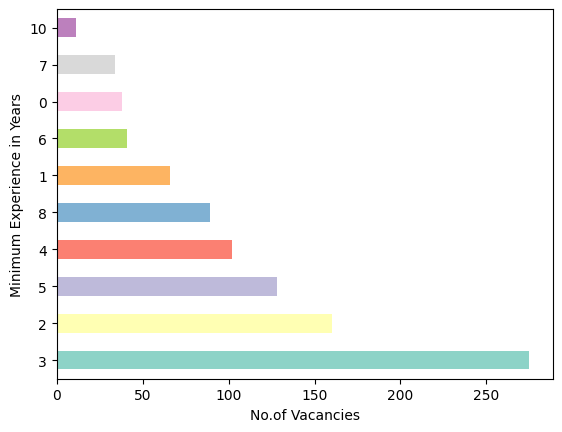

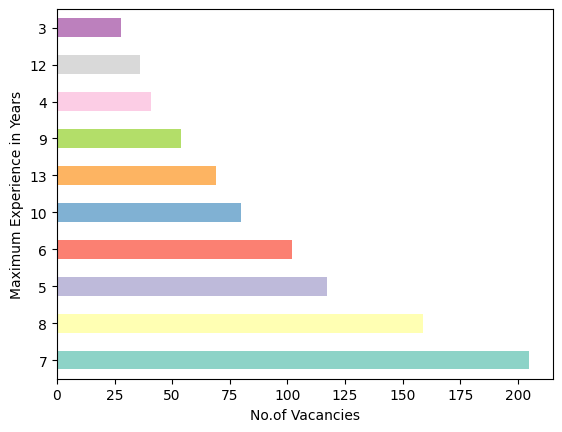

In [618]:
# since it's only one row, we'll just drop this from the list
condition = df['experience'].apply(lambda x: len(x) != 2)
df = df[~condition]
df.shape

# add columns to hold min/max experience
min_exp = []
max_exp = []

for row in df.itertuples():
    min_exp.append(int(row.experience[0]))
    max_exp.append(int(row.experience[1]))

df['min_exp'] = min_exp
df['max_exp'] = max_exp

# make another bar plot showing minimum and max
min_exp_count = df['min_exp'].value_counts()[:10]
min_exp_count.plot.barh(color=colors)
plt.xlabel("No.of Vacancies")
plt.ylabel("Minimum Experience in Years")
plt.show()

max_exp_count = df['max_exp'].value_counts()[:10]
max_exp_count.plot.barh(color=colors)
plt.xlabel("No.of Vacancies")
plt.ylabel("Maximum Experience in Years")
plt.show()

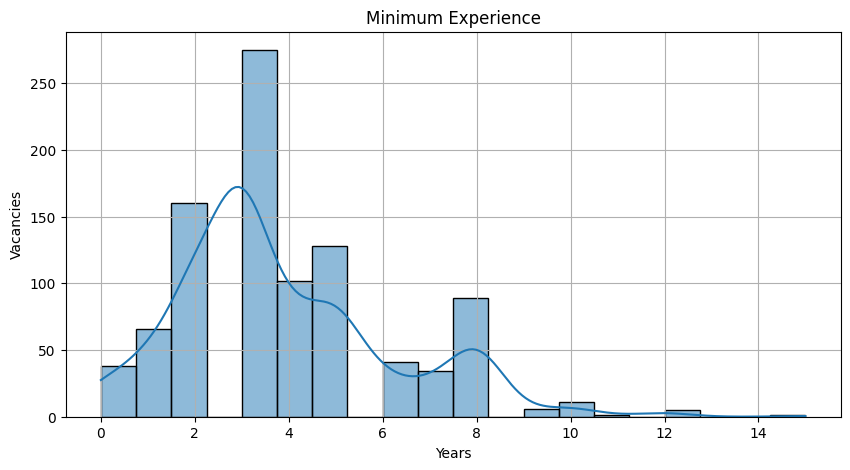

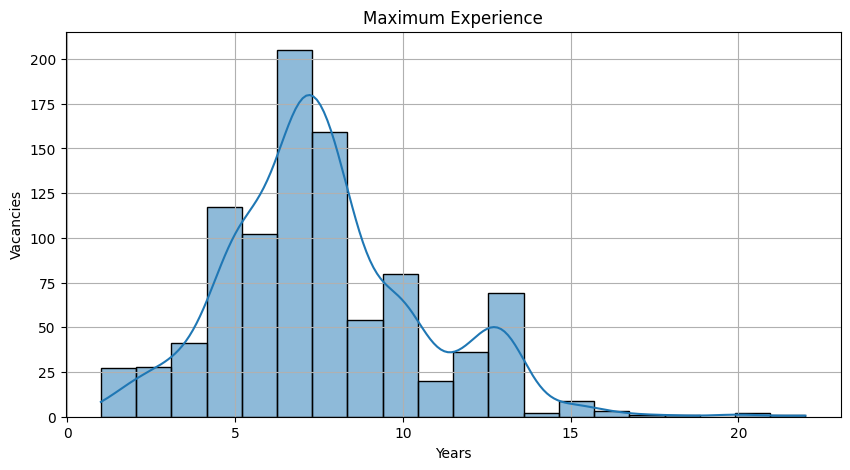

In [619]:
# plot a distribution of min/max years

plt.figure(figsize=(10, 5))
sns.histplot(df['min_exp'], bins=20, kde=True)
plt.title("Minimum Experience")
plt.xlabel("Years")
plt.ylabel("Vacancies")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['max_exp'], bins=20, kde=True)
plt.title("Maximum Experience")
plt.xlabel("Years")
plt.ylabel("Vacancies")
plt.grid(True)
plt.show()
